<a href="https://colab.research.google.com/github/project-ida/two-state-quantum-systems/blob/master/05-excitation-transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <a href="https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/05-excitation-transfer.ipynb" target="_parent"><img src="https://nbviewer.jupyter.org/static/img/nav_logo.svg" alt="Open In nbviewer" width="100"/></a>

# 5 - Excitation transfer

[Last time](https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/04-spin-boson-model.ipynb), we explored the spin boson model and found the surprising physics of down conversion - where many bosons are emitted/absorbed when a two state system (TSS) makes a transition. This is not what's usually taught to be possible in introductory quantum mechanics courses.

Today, we are going to extend the spin boson model by adding another another TSS into the mix. What new lessons does mother nature have for us...the clue is in the name of the tutorial 😉 .

This tutorial is split up into the following sections:
1. Recap
2. Adding more two state systems
3. Structure of the Hamiltonian
4. Parity
5. Energy level landscape $U=0$
6. Crossings and anti-crossings
7. Excitation transfer

In [1]:
# Libraries and helper functions

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image

import numpy as np
from itertools import product
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from qutip import *
from qutip.piqs import *

from scipy.optimize import minimize_scalar

# The helper file below brings functions created in previous tutorials
# make_df_for_energy_scan - we made this in tutorial 4
# make_braket_labels - we made this in tutorial 4
# simulate - we made this in tutorial 4
# 
from libs.helper_05_tutorial import *

## 5.1 - Recap

Let's remind ourselves of the Hamiltonian that we used in the last tutorial ([Tutorial 4](https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/04-spin-boson-model.ipynb))

$$H =  \frac{\Delta E}{2} \sigma_z + \hbar\omega\left(a^{\dagger}a +\frac{1}{2}\right) + U\left( a^{\dagger} + a \right)\sigma_x$$

where we recognise $\Delta E$ as the transition energy of the TSS, $\hbar\omega$ the energy of a single boson and $U$ as the strength of the interaction of the TSS with the boson field.

We described the states of the system above using the notation $|n,\pm \rangle$.

To help us transition to systems with many TSS, let's enumerate the states for the Hamiltonian above using an example where we only allow `max_bosons=4`.

In [2]:
max_bosons=4

We [previously](https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/04-spin-boson-model.ipynb#4.3---Structure-of-the-Hamiltonian) enumerated the states by doing:

In [3]:
# map from QuTiP number states to |n,±> states
possible_ns = range(0, max_bosons+1)
possible_ms = ["+","-"]
nm_list = [(n,m1) for (n,m1) in product(possible_ns, possible_ms)]

In [4]:
nm_list

[(0, '+'),
 (0, '-'),
 (1, '+'),
 (1, '-'),
 (2, '+'),
 (2, '-'),
 (3, '+'),
 (3, '-'),
 (4, '+'),
 (4, '-')]

and we represented these states in QuTiP using the tensor product (see [Tutorial 3](https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/03-a-two-state-system-in-a-quantised-field.ipynb#3.5---Describing-coupled-systems-in-QuTiP)). For example, the state $|1, +\rangle$ can be represented in QuTiP by:

In [5]:
#         bosons,                TSS1, 
tensor(basis(max_bosons+1,1), basis(2,0))

Quantum object: dims = [[5, 2], [1, 1]], shape = (10, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]

We also used tensor products for the operators that make up the Hamiltonian (See [Tutorial 4](https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/04-spin-boson-model.ipynb#4.2---Stationary-states)). Specifically:
- `two_state` = $\frac{1}{2}\sigma_z$
- `bosons` = $a^{\dagger}a +\frac{1}{2}$
- `interaction`= $\left( a^{\dagger} + a \right)\sigma_x$

In [6]:
a  = tensor(destroy(max_bosons+1), qeye(2))     # tensorised boson destruction operator
sx = tensor(qeye(max_bosons+1), sigmax())       # tensorised 𝜎𝑥 operator
sz = tensor(qeye(max_bosons+1),sigmaz())        # tensorised 𝜎𝑧 operator

two_state     =  1/2*sz                         # two state system energy operator   𝜎𝑧/2
bosons       =  (a.dag()*a+0.5)                 # boson energy operator              𝑎†𝑎+1/2
number        = a.dag()*a                       # boson number operator              𝑎†𝑎
interaction  = (a.dag() + a) * sx               # interaction energy operator        (𝑎†+𝑎)𝜎𝑥  

Now, we have recalled what we did before, we are in a good place to extend these ideas to include an extra TSS.

## 5.2 - Adding more two state systems

For this tutorial we will consider 2 identical TSS (`TSS_1` and `TSS_2`) whose interaction with the boson field is also identical. In this case, we can extend the single TSS Hamiltonian in the following way:

$$H =  \frac{\Delta E}{2} (\sigma_{z1} + \sigma_{z2}) + \hbar\omega\left(a^{\dagger}a +\frac{1}{2}\right) + U\left( a^{\dagger} + a \right)(\sigma_{x1} + \sigma_{x2})$$

where subscripts 1 and 2 refer to `TSS_1` and `TSS_2` respectively.

We will be referring to this Hamiltonian a lot in figure titles so we'll create a Latex variable so that it's easy to refer back to later.

In [7]:
H_latex = "$H = \Delta E /2 (\sigma_{z1} + \sigma_{z2}) + \hbar\omega(a^{{\dagger}}a +1/2) + U( a^{{\dagger}} + a )(\sigma_{x1} +\sigma_{x2} )$ "

How shall we describe the states of the system above? We can add another $\pm$ "index" to make the state notation $|n,\pm, \pm \rangle$.

Let's enumerate the states for the Hamiltonian above (again using `max_bosons=4`) by extending the ideas that we used for the single TSS - we just need to add an extra argument to the `product` function.

In [8]:
# map from QuTiP number states to |n,±, ±> states
possible_ns = range(0, max_bosons+1)
possible_ms = ["+","-"]
nmm_list = [(n,m1,m2) for (n,m1,m2) in product(possible_ns, possible_ms, possible_ms)]

In [9]:
nmm_list

[(0, '+', '+'),
 (0, '+', '-'),
 (0, '-', '+'),
 (0, '-', '-'),
 (1, '+', '+'),
 (1, '+', '-'),
 (1, '-', '+'),
 (1, '-', '-'),
 (2, '+', '+'),
 (2, '+', '-'),
 (2, '-', '+'),
 (2, '-', '-'),
 (3, '+', '+'),
 (3, '+', '-'),
 (3, '-', '+'),
 (3, '-', '-'),
 (4, '+', '+'),
 (4, '+', '-'),
 (4, '-', '+'),
 (4, '-', '-')]

The tensor products can also be extended by adding an extra argument. For example, the state  $|1,+, + \rangle$ is represented by:

In [10]:
#           bosons,             TSS_1,        TSS_2
tensor(basis(max_bosons+1,1), basis(2,0), basis(2,0))

Quantum object: dims = [[5, 2, 2], [1, 1, 1]], shape = (20, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]

Now we do the same for the operators:

- `two_state_1` = $\frac{1}{2}\sigma_{z1}$
- `two_state_2` = $\frac{1}{2}\sigma_{z2}$
- `bosons` = $a^{\dagger}a +\frac{1}{2}$
- `interaction_1`= $\left( a^{\dagger} + a \right)\sigma_{x1}$
- `interaction_2`= $\left( a^{\dagger} + a \right)\sigma_{x2}$

In [11]:
a     = tensor(destroy(max_bosons+1), qeye(2), qeye(2))     # tensorised boson destruction operator
sx1   = tensor(qeye(max_bosons+1), sigmax(), qeye(2))       # tensorised 𝜎𝑥1 operator 
sx2   = tensor(qeye(max_bosons+1), qeye(2), sigmax())       # tensorised 𝜎𝑥2 operator 
sz1   = tensor(qeye(max_bosons+1), sigmaz(), qeye(2))       # tensorised 𝜎z1 operator 
sz2   = tensor(qeye(max_bosons+1), qeye(2), sigmaz())       # tensorised 𝜎z2 operator 

two_state_1     =  1/2*sz1                             # two_state_1 energy operator        𝜎𝑧1/2
two_state_2     =  1/2*sz2                             # two_state_2 energy operator        𝜎𝑧2/2
bosons          = (a.dag()*a+0.5)                      # boson energy operator              𝑎†𝑎+1/2
number          = a.dag()*a                            # boson number operator              𝑎†𝑎
interaction_1   = (a.dag() + a) * sx1                  # interaction_1 energy operator      (𝑎†+𝑎)𝜎𝑥1  
interaction_2   = (a.dag() + a) * sx2                  # interaction_2 energy operator      (𝑎†+𝑎)𝜎𝑥2 

## 5.3  - Structure of the Hamiltonian

In [tutorial 4](https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/04-spin-boson-model.ipynb#4.3---Structure-of-the-Hamiltonian), we learnt a lot from looking at the Hinton diagram of the Hamiltonian. What we we learn this time?

Let's use an example Hamiltonian with $\Delta E = \omega = U = 1$ for this visual exploration.

In [12]:
H = 1*two_state_1 + 1*two_state_2 + 1*bosons + 1*interaction_1 + 1*interaction_2

Let's not forget to make the pretty bra-ket labels for plotting. We are making use of the `make_braket_labels` function that we created last time and have imported from a helper file at the top of the notebook.

In [13]:
bra_labels, ket_labels = make_braket_labels(nmm_list)

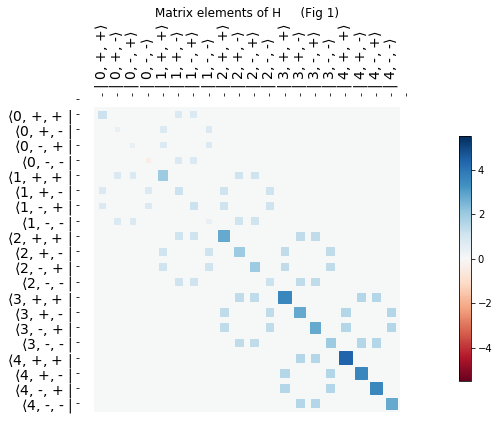

In [14]:
f, ax = hinton(H, xlabels=ket_labels, ylabels=bra_labels)
ax.tick_params(axis='x',labelrotation=90,)
ax.set_title("Matrix elements of H     (Fig 1)");

As we might have guessed, the Hinton diagram is more complicated than for a single TSS. Each state is connected to twice as many states as previously. For example, $|0,+, + \rangle$ is directly coupled to the following 2 states:
- $|1,+, - \rangle$
- $|1,-, + \rangle$

Just as in the last tutorial, we can draw indirect paths connecting different states to get a feeling for what dynamics might be possible. There are many more paths compared to a single TSS - we'll just look at a few.

For example:

                Matrix elements of H     (Fig 2)


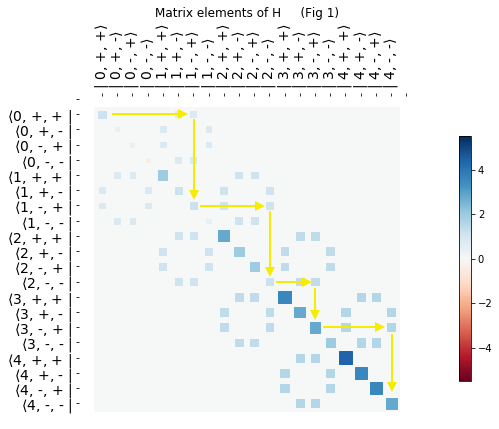

In [15]:
print("                Matrix elements of H     (Fig 2)")
Image(filename='./img/05-hinton-01.png') 

In Fig 2, we imagine that we start in the state $|0,+, + \rangle $. Similar to the previous tutorial, we find that we are indirectly connected to many states with different numbers of bosons:

$|0,+, + \rangle \rightarrow |1,+, - \rangle \rightarrow |2,-, - \rangle \rightarrow |3,+, - \rangle \rightarrow |4,-, - \rangle$

What can we learn from this pathway?

We can expect that the indirect path from $|0,+, + \rangle \rightarrow |2,-, - \rangle$ could be physically realised by each TSS emitting a single boson whose energy matches the TSS transision energy, i.e. $\Delta E = \omega$. We've seen similar physics for single TSS - nothing new here.

We can also expect that the indirect path from $|0,+, + \rangle \rightarrow |4,-, - \rangle$ could be physically realised by each TSS emitting a 2 bosons whose energy is half the TSS transision energy, i.e. $\Delta E = 2\omega$. This is another example of down conversion that we found last time - again nothing new here.

We can also draw quite different pathways like the one below.

                Matrix elements of H     (Fig 3)


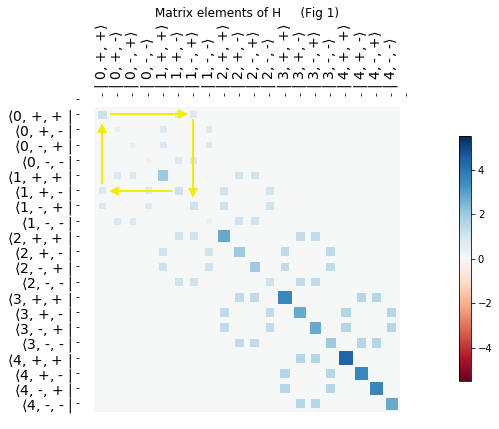

In [16]:
print("                Matrix elements of H     (Fig 3)")
Image(filename='./img/05-hinton-02.png') 

In Fig 3 above, we imagine that we start in the state $|1,+, - \rangle $ and then through indirect connections to states with a different number of bosons we end up back with 1 boson but the "+" and "-" switch places, i.e.

$|1,+, - \rangle \rightarrow |0,+, + \rangle \rightarrow |1,-, + \rangle$

We could describe such an indirect path from $|1,+, - \rangle \rightarrow |1,-, + \rangle$ as **excitation transfer** because the "excitation" (i.e. the +) moves from one TSS to another - this is something that we've not encountered before and we'd like to explore this in more detail through simulation.

Before we are able to simulate, we need to also extend the ideas of party that we [introduced last time](https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/04-spin-boson-model.ipynb#4.4---Parity) and bring everything together in a convenient function that we can use again and again.


## 5.4 - Parity
In [tutorial 4](https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/04-spin-boson-model.ipynb#4.4---Parity) we discovered that two distinct parity universes co-existed inside the Hamiltonian and that each universe could be be treated in isolation.

We calculated parity using the operator $\sigma_z e^{i\pi n}$ where $n$ is the boson number operator.

We can guess at how to extend this idea to 2 TSS - let's try  $\sigma_{z1}\sigma_{z2} e^{i\pi n}$.

In [17]:
P = sz1*sz2*(1j*np.pi*number).expm()              # parity operator

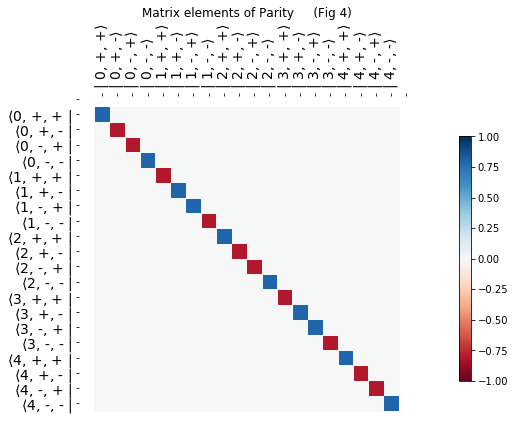

In [18]:
f, ax = hinton(P, xlabels=ket_labels, ylabels=bra_labels)
ax.tick_params(axis='x',labelrotation=90)
ax.set_title("Matrix elements of Parity     (Fig 4)");

Fig 4 shows us that our guess at parity creates a binary $\pm 1$ similar to what we saw in the last tutorial - so far so good. The most important question is, does our guess at parity commute with the Hamiltonian - if it does then it is conserved and we therefore have a well defined parity operator that we can use to split the universes.

In [19]:
commutator(H,P).full

<bound method Qobj.full of Quantum object: dims = [[5, 2, 2], [5, 2, 2]], shape = (20, 20), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

We have zero commutator - this is exactly what we need.

We are now ready to put this all together in much the same way we did in the last tutorial, i.e. create a function that can extract the even parity universe (+1) or the odd parity universe (-1).

In [20]:
def make_operators(max_bosons, parity=0):
    
    a     = tensor(destroy(max_bosons+1), qeye(2), qeye(2))     # tensorised boson destruction operator
    sx1   = tensor(qeye(max_bosons+1), sigmax(), qeye(2))       # tensorised 𝜎𝑥1 operator 
    sx2   = tensor(qeye(max_bosons+1), qeye(2), sigmax())       # tensorised 𝜎𝑥2 operator 
    sz1   = tensor(qeye(max_bosons+1), sigmaz(), qeye(2))       # tensorised 𝜎z1 operator 
    sz2   = tensor(qeye(max_bosons+1), qeye(2), sigmaz())       # tensorised 𝜎z2 operator 

    two_state_1     =  1/2*sz1                                  # two state system energy operator   𝜎𝑧1/2
    two_state_2     =  1/2*sz2                                  # two state system energy operator   𝜎𝑧2/2
    bosons          = (a.dag()*a+0.5)                           # boson energy operator              𝑎†𝑎+1/2
    number          = a.dag()*a                                 # boson number operator              𝑎†𝑎
    interaction_1   = (a.dag() + a) * sx1                       # interaction energy operator       (𝑎†+𝑎)𝜎𝑥1  
    interaction_2   = (a.dag() + a) * sx2                       # interaction energy operator       (𝑎†+𝑎)𝜎𝑥2  
    
    P = sz1*sz2*(1j*np.pi*number).expm()                        # parity operator 
    
    # map from QuTiP number states to |n,±, ±> states
    possible_ns = range(0, max_bosons+1)
    possible_ms = ["+","-"]
    nmm_list = [(n,m1,m2) for (n,m1,m2) in product(possible_ns, possible_ms, possible_ms)]
    
    # only do parity extraction if a valid parity is being used
    if (parity==1) | (parity==-1):
        p           = np.where(P.diag()==parity)[0]
        
        two_state_1     = two_state_1.extract_states(p)
        two_state_2     = two_state_2.extract_states(p)
        bosons          = bosons.extract_states(p)
        number          = number.extract_states(p)
        interaction_1   = interaction_1.extract_states(p)
        interaction_2   = interaction_2.extract_states(p)
        nmm_list        = [nmm_list[i] for i in p]
    
    
    return two_state_1, two_state_2, bosons, interaction_1, interaction_2, number, nmm_list

So, we've got the parity universes under control and we've also got an idea of what dynamics might be possible from exploring the Hinton diagram. Let's now see if we can connect these dynamics up with features in the energy level diagrams just as we did in the last tutorial. This will put us in the best place to be able to interpret the simulations we will make.

We start without any coupling between the TSS and the field, i.e. $U=0$ to get a sense of the landscape.

### 5.5 - Energy level landscape $U=0$

We will work with $\omega = 1$ throughout the rest of the tutorial and we will also allow up to 6 bosons in our simulations, i.e. `max_bosons=6`.

Let's take a look at the energy levels for odd and even parity universes when there is no couping between the TSS and the boson field.

Note, we will make use of the function `make_df_for_energy_scan` that we created in the last tutorial and is imported from the helper file at the top of the notebook.

In [21]:
# ODD PARITY

# make the operators
two_state_1, two_state_2, bosons, interaction_1, interaction_2, number, nmm_list = make_operators(
    max_bosons=6, parity=-1)

# prepare data structure for the energy level scan
df_odd = make_df_for_energy_scan("$\Delta E$", -4, 4, 201, two_state_1.shape[0])

# fill the data structure with eigevalues of the Hamiltonian i.e. the energy levels
for i, row in df_odd.iterrows():
    H =  row["$\Delta E$"]*two_state_1+ row["$\Delta E$"]*two_state_2 + 1*bosons 
    evals, ekets = H.eigenstates()
    df_odd.iloc[i,1:] = evals 

In [22]:
# EVEN PARITY

# make the operators
two_state_1, two_state_2, bosons, interaction_1, interaction_2, number, nmm_list = make_operators(
    max_bosons=6, parity=1)

# prepare data structure for the energy level scan
df_even = make_df_for_energy_scan("$\Delta E$", -4, 4, 201, two_state_1.shape[0])

# fill the data structure with eigevalues of the Hamiltonian i.e. the energy levels
for i, row in df_even.iterrows():
    H =  row["$\Delta E$"]*two_state_1+ row["$\Delta E$"]*two_state_2 + 1*bosons 
    evals, ekets = H.eigenstates()
    df_even.iloc[i,1:] = evals 

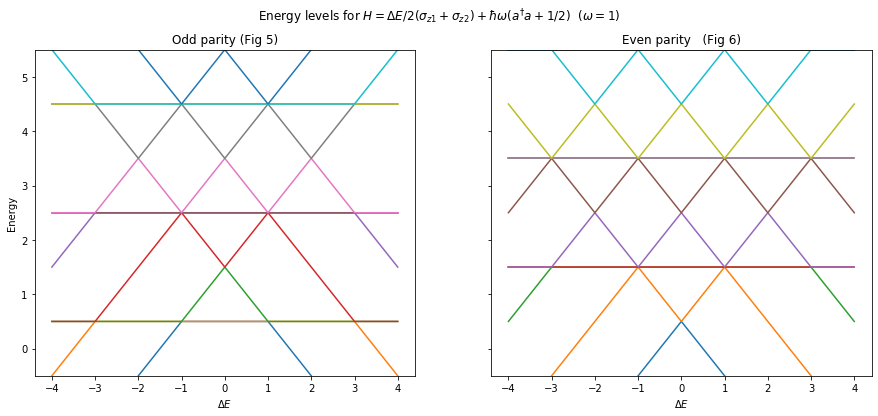

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6), sharey=True)

fig.suptitle("Energy levels for $H = \Delta E /2 (\sigma_{z1} + \sigma_{z2}) + \hbar\omega(a^{{\dagger}}a +1/2) $  ($\omega=1$)")


df_odd.plot(x="$\Delta E$",ylim=[-0.5,5.5],legend=False, 
        title="Odd parity (Fig 5)",  ax=axes[0]);

df_even.plot(x="$\Delta E$",ylim=[-0.5,5.5],legend=False, 
        title="Even parity   (Fig 6)",  ax=axes[1]);

axes[0].set_ylabel("Energy");



What can we say about th energy levels in Figs 5 and 6?

Compared to [Fig 1 of tutorial 4](https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/04-spin-boson-model.ipynb#4.2.1---Spin-boson-landscape-$U=0$), we have some similarities and some differences:
- Similarity - levels that trend up and down with changing $\Delta E$. These correspond to states like $|n,+,+\rangle$ and $|n,-,-\rangle$. For example in Fig 6 for small positive $\Delta E$ (referring to blue squares in Fig 4 for even parity states) we have:
  - $|0,-,-\rangle$ - blue
  - $|0,+,+\rangle$ - orange 
  - $|2,-,-\rangle$ - purple  
  - $|2,+,+\rangle$ - brown 
  - $|4,-,-\rangle$ - yellow 
  - $|4,+,+\rangle$ - sky-blue 
- Difference - horizontal levels. These correspond to combinations of $|n,+,-\rangle$ and $|n,-,+\rangle$ which give is no overall "excitation" i.e. equal amounts of + and -. This kind of combination of basis states is often referred to as an [entangled state](https://en.wikipedia.org/wiki/Quantum_entanglement#Pure_states). The subject of quantum entanglement deserves at least a whole tutorial, so we'll come back to it another time.

Thinking more carefully about these unfamiliar horizontal levels, there are 2 ways we can combine $|n,+,-\rangle$ and $|n,-,+\rangle$ together:
- $|n,+,-\rangle + |n,-,+\rangle$ 
- $|n,+,-\rangle  - |n,-,+\rangle$ 

These states are reminiscent of the "in phase" and "out of phase" states that we described [back in tutorial 1](https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/01-an-isolated-two-state-system.ipynb#1.2-Coupling-between-two-states-of-the-same-energy).  The two combinations create an expectation that each horizontal line in 6 is in fact 2 horizontal lines on top of each other, i.e

 - $|1,+,-\rangle \pm |1,-,+\rangle $ - green/red
 - $|3,+,-\rangle \pm |3,-,+\rangle $ - pink/grey

What else can we say?

When looking at where the levels cross, there appear to be two different situations:
- 2 levels come together - we've seen this before and we expect these to form anti-crossings when we switch the coupling on (i.e. $U\neq 0$)
- 4 levels come together - we've not encountered this before so we need to explore it further

From now on we'll continue our exploration with even parity, i.e Fig 6. 

Let's switch on the coupling and see if there are any surprises.

## 5.6 - Crossings and anti-crossings

We'll create a relatively strong coupling to start with i.e. $U=0.1$. This way we can easily spot the changes in the energy level diagram.

In [24]:
# We re-use operators that made Fig 6 (these had even parity) and just add the interaction terms
for i, row in df_even.iterrows():
    H =  row["$\Delta E$"]*two_state_1+ row["$\Delta E$"]*two_state_2 + 1*bosons + 0.1*interaction_1 + 0.1*interaction_2
    evals, ekets = H.eigenstates()
    df_even.iloc[i,1:] = evals 

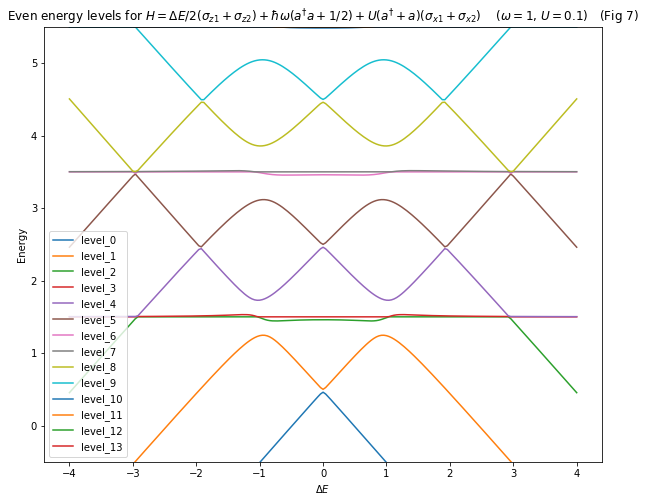

In [25]:
df_even.plot(x="$\Delta E$",ylim=[-0.5,5.5],legend=True, 
        title=f"Even energy levels for {H_latex}   ($\omega=1$, $U=0.1$)   (Fig 7)",
             figsize=(10,8));

plt.ylabel("Energy");


There are many things we can see is Fig 7:
1. Where 2 levels have come together (e.g. levels 4 and 5) we see an anti-crossings as we have come to expect from interacting levels
2. The horizontal levels of Fig 6 have split into 2 levels as we suspected. This confirms that we do indeed have 4 levels coming together at some anti-crossings, e.g. levels 1,2,3,4
3. There appear to still be genuine crossings between some levels, most strikingly seen at the intersection of levels 2 and 3 - this indicates there might be non interacting sub-universes with each parity universe 🤔

There is a lot to explore and understand here. We'll start with point 1, i.e. two levels anti-crossing, as this is the most familiar to us, we'll then take a look at point 3 i.e. the mystery crossing between the states with no overall excitation. Then we'll finish off with point 2, i.e. the unfamiliar 4 level anti-crossing.

### 5.6.1 - Two Level anti-crossing

In fig 7, levels 4 an 5 anti-cross at around $\Delta E = 2$. This anti-crossing looks like it could be linked to the $|0,+, + \rangle \rightarrow |4,-, - \rangle$ down conversion that we talked about when we explored the Hinton diagram. Let's see if we can confirm this down conversion via simulation (just as we did in [Fig 12 of tutorial 4](https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/04-spin-boson-model.ipynb#4.5---Down-conversion)). 

Rather than manually zoom in on the anti-crossing to get a more precise value of $\Delta E$ to use in the simulation, we will automate the process using [`minimize_scalar`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize_scalar.html) from [`scipy`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize_scalar.html).

How will we use `minimize_scalar`? We first need to provide a function that calculates the difference in the energies of two levels.

In [26]:
def level_difference(DeltaE, omega, U, level_number):
    H = DeltaE*two_state_1 + DeltaE*two_state_2 + omega*bosons + U*interaction_1 + U*interaction_2
    evals, ekets = H.eigenstates()
    return np.abs(evals[level_number] - evals[level_number-1])

We then pass this `level_difference` function to `minimise_scalar`. The first argument of `level_difference` (i.e. `DeltaE`) will be used by `minimize_scalar` as a variable and the rest will be considered as "arguments" (i.e. fixed constants). Finally, we must specify `bounds` (i.e. min and max `DeltaE`) inside of which we expect to find the anti-crossing.

Let's give it a go using:
- `omega = 1`
- `U = 0.1`
- `level_number = 5`
- `bounds = [1.9, 2]`

In [27]:
# oemga = 1
# U = 0.1
# level_number 5 - this will allow us to calculate level_5/4 energy difference
anti_crossing = minimize_scalar(level_difference, args=(1, 0.1, 5), method="Bounded", bounds=[1.9, 2])

In [28]:
anti_crossing

     fun: 9.469828282338e-05
 message: 'Solution found.'
    nfev: 14
  status: 0
 success: True
       x: 1.9328592876515323

We see that the true anti-crossing occurs at $\Delta E = 1.9328593467366724$.

We can now use this value to create the Hamiltonian for our simulation.

> Also feel free to adjust the value of  $\Delta E$ and see how sensitive the results are to the precise value of the anti-crossing.

In [29]:
H = anti_crossing.x*two_state_1 + anti_crossing.x*two_state_2 + 1*bosons + 0.1*interaction_1 + 0.1*interaction_2

We want to start the system off in the $|0,+, + \rangle$ state - this should be the first state in the state list, let's check.

In [30]:
nmm_list[0]

(0, '+', '+')

Great. We can now set up the initial state by using the `basis` function as we have done before.

In [31]:
psi0 = basis(len(nmm_list), 0)

Now we are ready to simulate

In [32]:
times = np.linspace(0.0, 100000.0, 10000)
P, psi = simulate(H, psi0, times)

We need to recreate the bra-ket labels because we are now working only with even parity states.

In [33]:
bra_labels, ket_labels = make_braket_labels(nmm_list)

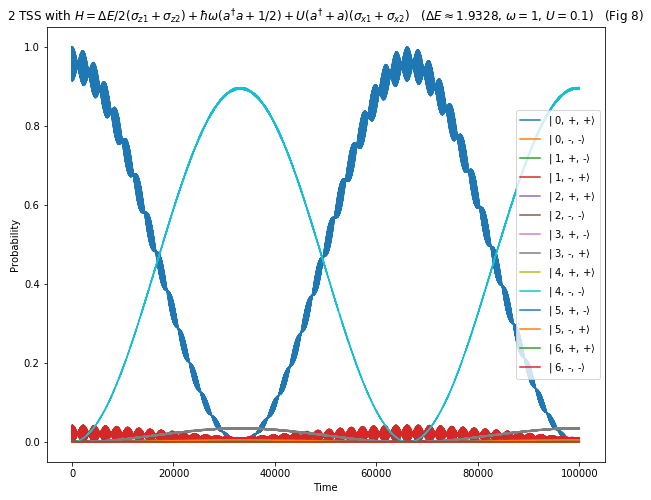

In [34]:
plt.figure(figsize=(10,8))
for i in range(0,P.shape[0]):
    plt.plot(times, P[i,:], label=f"{ket_labels[i]}")
plt.ylabel("Probability")
plt.xlabel("Time")
plt.legend(loc="right")
plt.title(f"2 TSS with {H_latex}  ($\Delta E \\approx 1.9328$, $\omega=1$, $U=0.1$)   (Fig 8)")
plt.show();

Fig 8 shows exactly what we expected i.e. both TSS transition from "+" to "-" each giving of 2 bosons in the process, i.e. $|0,+, + \rangle \rightarrow |4,-, - \rangle$.

### 5.6.2 - Mystery crossings

In fig 7, we found something unexpected for the energy levels corresponding to no overall excitation, i.e. those consisting of equal number of "+" and "-" for the TSS. We found that e.g. levels 2 and 3 appeared to cross each other. Considering that we are in an even parity universe, the expectation is that all levels can interact with each other and create anti-crossings in the process - so why don't levels 2 and 3 do this?

To dig a little deeper, we'll set $\Delta E = 0$ and inspect levels 2 and 3 in more detail - specifically we'll look at the corresponding eigenstates.

In [35]:
DeltaE = 0

In [36]:
H = DeltaE*two_state_1 + DeltaE*two_state_2 + 1*bosons + 0.1*interaction_1 + 0.1*interaction_2

In [37]:
evals, ekets = H.eigenstates()

Let's first look at the energy of levels 2 and 3

In [38]:
print(f"Energy of level 2 = {evals[2]}")
print(f"Energy of level 3 = {evals[3]}")

Energy of level 2 = 1.4600000002246054
Energy of level 3 = 1.5000000000000009


How intriguing, the energy of level 3 is exactly 1.5 - just as as it was when we didn't have any coupling between the TSS and the boson field.

Now let's look at the corresponding eigenstates using a helper function `prettify_states` that we imported from the helper file.

In [39]:
prettify_states(ekets, nmm_list)[[2,3]]

,2,3
"(0, +, +)",-0.1+0.0j,0.0+0.0j
"(0, -, -)",-0.1+0.0j,0.0+0.0j
"(1, +, -)",-0.7+0.0j,0.7+0.0j
"(1, -, +)",-0.7+0.0j,-0.7+0.0j
"(2, +, +)",0.2+0.0j,0.0+0.0j
"(2, -, -)",0.2+0.0j,0.0+0.0j
"(3, +, -)",-0.0+0.0j,0.0+0.0j
"(3, -, +)",-0.0+0.0j,0.0+0.0j
"(4, +, +)",0.0+0.0j,0.0+0.0j
"(4, -, -)",0.0+0.0j,0.0+0.0j


We can see that the eigenstates corresponding to levels 2 and 3 are normalised versions of: 
- Level 2 = $|1,+,-\rangle  + |1,-,+\rangle$ +  other states with boson number different from 1
- Level 3 = $|1,+,-\rangle  - |1,-,+\rangle$ 

This pattern persists for all $\Delta E$ - try it out for yourself by changing the $\Delta E$ in the above Hamiltonian. There is always a horizontal level corresponding to  $|1,+,-\rangle  - |1,-,+\rangle$ with energy 1.5. This level (and others like it with different boson number) does not couple to others and so does indeed live in its own sub-universe.

Why is it that changing plus to minus in $|1,+,-\rangle  \pm |1,-,+\rangle$ makes such a difference? What is the nature of this other sub-universe? They are important questions but they take us somewhat away from the primary mission of this tutorial. We'll come back to this in the next tutorial.

> For those who just can't wait that long, it has to do with angular momentum and spin

For now, what we can confidently say is that when we see a 4 level anti-crossing it's actually only 3 levels that are interacting to produce the energy splitting - the other level is a non-interacting one of the form $|n,+,-\rangle  - |n,-,+\rangle$. With that said, let's take a look at these unfamiliar many level anti-crossings.

### 5.6.3 - Beyond simple anti-crossings

In fig 7, there is a 4 level "anti-crossing" around $\Delta E = 1$. Because $\Delta E = \omega$ at this point, we suspect that the transition $|0,+, + \rangle \rightarrow |2,-, - \rangle$ (that we spoke of during exploration of the Hinton diagram) might be active here. 

Let's zoom in a take a closer look before we head straight into simulation.

In [40]:
df_even = make_df_for_energy_scan("$\Delta E$", 0.7, 1.3, 201, two_state_1.shape[0])

for i, row in df_even.iterrows():
    H =  row["$\Delta E$"]*two_state_1+ row["$\Delta E$"]*two_state_2 + 1*bosons + 0.1*interaction_1 + 0.1*interaction_2
    evals, ekets = H.eigenstates()
    df_even.iloc[i,1:] = evals 

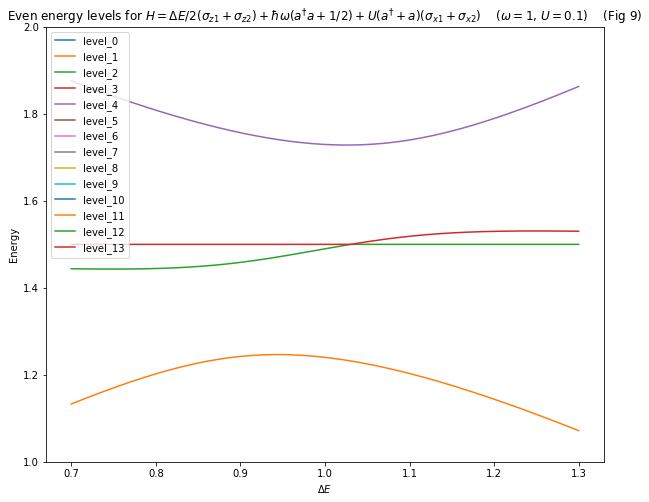

In [41]:
df_even.plot(x="$\Delta E$",ylim=[1,2],legend=True, 
        title=f"Even energy levels for {H_latex}   ($\omega=1$, $U=0.1$)    (Fig 9)",
             figsize=(10,8));

plt.ylabel("Energy");

When looking at levels 2 and 3 in fig 9, we should try and ignore the horizontal part (the non interactive level) and instead imagine the elongated "S" looking shape is a single energy level - let's call it level S.

We can immediately see from fig 9 that the notion of an anti-crossing is now somewhat ill defined because things don't look very symmetric. In particular:
- The extrema of the upper (purple) and lower (orange) levels don't occur at the same $\Delta E$
- The upper and lower levels come closest to the middle level S at a $\Delta E$ that doesn't not coincide with their extrema

It is therefore difficult to choose an appropriate $\Delta E$ for a simulation. We do know that as $U \rightarrow 0$, all the levels come together at $\Delta E=1 $ (as we saw in fig 6), so let's reduce $U$ by a factor of 10 to $U=0.01$ and set $\Delta E=1 $ for this simulation and see how we go.

In [42]:
H = 1*two_state_1 + 1*two_state_2 + 1*bosons + 0.01*interaction_1 + 0.01*interaction_2

We'll again start in the $|0,+, + \rangle$ state.

In [43]:
psi0 = basis(len(nmm_list), 0)

In [44]:
times = np.linspace(0.0, 1000.0, 10000)
P, psi = simulate(H, psi0, times)

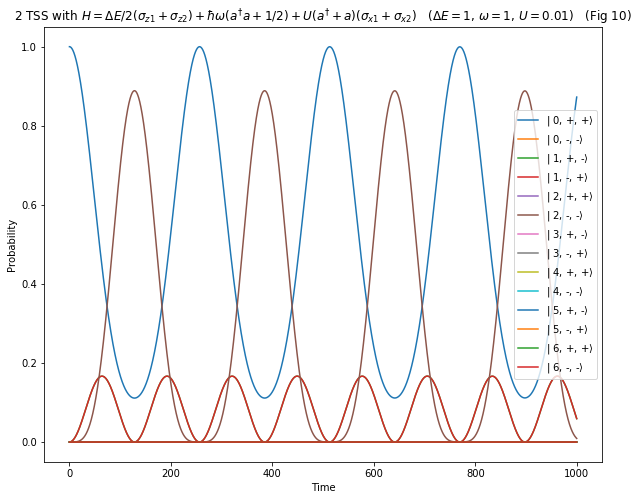

In [45]:
plt.figure(figsize=(10,8))
for i in range(0,P.shape[0]):
    plt.plot(times, P[i,:], label=f"{ket_labels[i]}")
plt.ylabel("Probability")
plt.xlabel("Time")
plt.legend(loc="right")
plt.title(f"2 TSS with {H_latex}  ($\Delta E = 1$, $\omega=1$, $U=0.01$)   (Fig 10)")
plt.show();




Fig 10 indeed shows the emission of a single boson from each TSS as we predicted when we explored the Hinton diagram.

>As an aside, you might be wondering why we don't see a full oscillation in probability from 1 to 0 for $|0,+,+ \rangle$ and $|2,-,- \rangle$. We saw in Tutorial 4 (fig 2), that as the boson number increased the separation in levels at anti-crossings also increased - this tells us that the boson number is involved in the amount of coupling between any two levels. Because $|0,+,+ \rangle \rightarrow |2,-,- \rangle$ involves the coupling of 3 levels of different boson number (the third being the intermediate level $|1,+,-\rangle + |1,-,+\rangle$), an asymmetry develops between the intermediate state and the upper/lower states. This asymmetry is then reflected in the time evolution of Fig 10.

Things here are not quite as simple as a two level anti-crossing, but our intuition from looking at both the Hinton diagram and the energy levels still gave us the right idea.

What about the novel feature we found in the Hinton diagram - the suggestion of something we termed excitation transfer?

## 5.7 - Excitation transfer

The Hinton diagram in fig 3 hinted at an indirect transition of the form $|1,+, - \rangle \rightarrow |1,-, + \rangle$. Since this transition appears to be mediated by  $ |0,+, + \rangle$ (among others), which has one less boson, we should be able simulate excitation transfer by re-running the last simulation with the starting condition $|1,+, - \rangle$ instead of $|0,+, + \rangle$.

What does $|1,+, - \rangle$ correspond to in QuTiP?

In [46]:
nmm_list

[(0, '+', '+'),
 (0, '-', '-'),
 (1, '+', '-'),
 (1, '-', '+'),
 (2, '+', '+'),
 (2, '-', '-'),
 (3, '+', '-'),
 (3, '-', '+'),
 (4, '+', '+'),
 (4, '-', '-'),
 (5, '+', '-'),
 (5, '-', '+'),
 (6, '+', '+'),
 (6, '-', '-')]

We need state number 2.

In [47]:
nmm_list[2]

(1, '+', '-')

In [48]:
psi0 = basis(len(nmm_list), 2)
times = np.linspace(0.0, 1000.0, 10000)
P, psi = simulate(H, psi0, times)

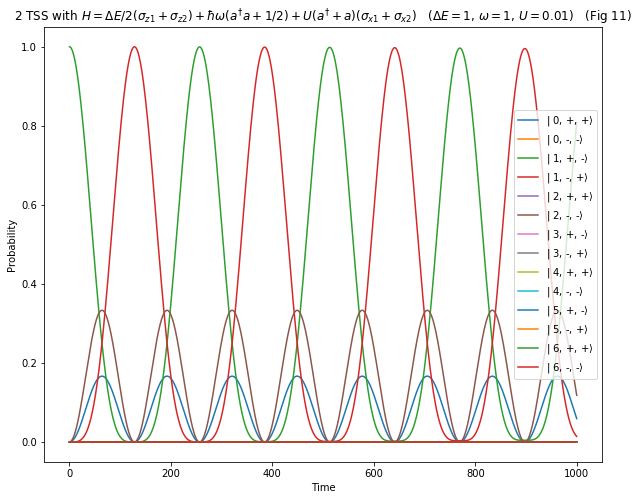

In [49]:
plt.figure(figsize=(10,8))
for i in range(0,P.shape[0]):
    plt.plot(times, P[i,:], label=f"{ket_labels[i]}")
plt.ylabel("Probability")
plt.xlabel("Time")
plt.legend(loc="right")
plt.title(f"2 TSS with {H_latex}  ($\Delta E = 1$, $\omega=1$, $U=0.01$)   (Fig 11)")
plt.show();



Success, we do indeed see the system move from $|1,+, - \rangle \rightarrow |1,-, + \rangle$ as we predicted.

We can interpret the excitation transfer in Fig 11 in the following ways:
1. 

  - TSS_1 (the one initially in the "+" state) transitions to the lower "-" state releasing energy
  - The energy goes into emitting an extra boson, taking the field from 1 to 2 bosons
  - TSS_2 (the one initially in the "-" state) absorbs a boson taking the field from 2 to 1 boson
  
  
2. 
  - TSS_2 (the one initially in the "-" state) absorbs energy and transitions to upper "+" state
  - This energy comes from the boson field, taking the number of bosons from 1 to 0
  - TSS_1 (the one initially in "+" state) emits a boson taking the field from 0 to 1 boson
  
 
This mechanics as described above leads us to a mental model of excitation transfer as simply the exchange of bosons between one TSS and another - each boson carrying the entire transition energy of the TSS. This is indeed one way that excitation transfer can occur, but it's not the only way. The entire transition energy $\Delta E$ can be conferred from one TSS to another without a single boson being emitted 🤯 . 

Skeptical...you should be. Let's see it in action and then try and understand it.

### Non radiative excitation transfer

We're now going to perform the same simulation as above but this time we will set $\Delta E = 2.5\omega$. It is now not possible for an integer number of bosons to transmit the transition energy $\Delta E$ from TSS_1 to TSS_2.

In [50]:
H = 2.5*two_state_1 + 2.5*two_state_2 + 1*bosons + 0.01*interaction_1 + 0.01*interaction_2

We'll again start the system in the state $|1,+,- \rangle$.

In [51]:
psi0 = basis(len(nmm_list), 2)

In [52]:
times = np.linspace(0.0, 100000.0, 10000)
P, psi = simulate(H, psi0, times)

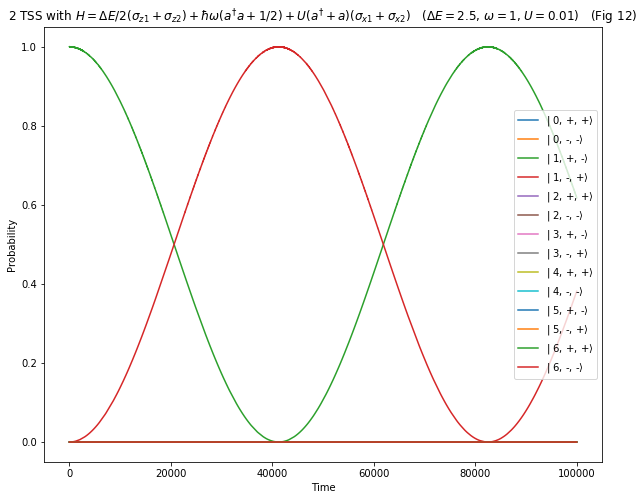

In [53]:
plt.figure(figsize=(10,8))
for i in range(0,P.shape[0]):
    plt.plot(times, P[i,:], label=f"{ket_labels[i]}")
plt.ylabel("Probability")
plt.xlabel("Time")
plt.legend(loc="right")
plt.title(f"2 TSS with {H_latex}  ($\Delta E = 2.5$, $\omega=1$, $U=0.01$)   (Fig 12)")
plt.show();


As you can see, Fig 12 shows that excitation can be transfered from one TSS_1 to TSS_2 without bosons having any significant chance of being emitted.

How is it possible to transfer energy quantum mechanically without radiation of bosons? We can't do the topic justice in a single notebook, but we can point to similar phenomenon in classical physics. Specifically, the [near field](https://en.wikipedia.org/wiki/Near_and_far_field) is the non-radiative part of the electromagnetic field that can be used to e.g. [transfer power wirelessly](https://en.wikipedia.org/wiki/Wireless_power_transfer) from one device to another without radiating the power in all directions (as we would associate with something like radio transmitter). 

In the context of quantum mechanics, in systems more physically realistic than what we describe in this notebook, such non radiative transfers of energy are made by something called virtual bosons. In general, [virtual particles](https://profmattstrassler.com/articles-and-posts/particle-physics-basics/virtual-particles-what-are-they) are quite a complicated business so we will return to them in a later tutorial. We can however say that their application to the mature area of [Resonance Energy Transfer](https://www.frontiersin.org/articles/10.3389/fphy.2019.00100/full) (used to explain certain dynamics of photosynthesis in plants among other things) is common place.

We have made a most striking observation, but let's not get too carried away with the surprise of it all. We should make the connection back to the energy level diagram as we always try to do. Let's zoom in in the area around $\Delta E = 2.5$.

In [54]:
df_even = make_df_for_energy_scan("$\Delta E$", 2.5, 2.6, 201, two_state_1.shape[0])

for i, row in df_even.iterrows():
    H =  row["$\Delta E$"]*two_state_1+ row["$\Delta E$"]*two_state_2 + 1*bosons + 0.01*interaction_1 + 0.01*interaction_2
    evals, ekets = H.eigenstates()
    df_even.iloc[i,1:] = evals 

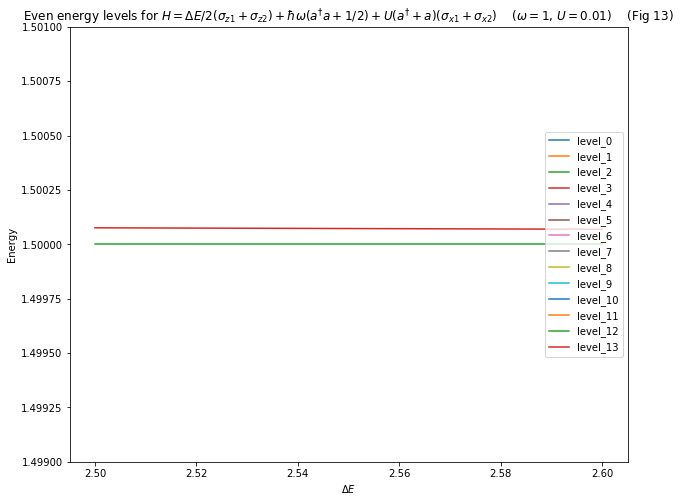

In [55]:
ax = df_even.plot(x="$\Delta E$",ylim=[1.499,1.501],legend=True, 
        title=f"Even energy levels for {H_latex}   ($\omega=1$, $U=0.01$)    (Fig 13)",
             figsize=(10,8));

plt.ylabel("Energy")
plt.legend(loc="right")

# Use the following to remove the y-offset from the yaxis if you find there is one
ax.yaxis.get_major_formatter().set_useOffset(False);

In fig 13 we have:
- Level 2 (green) $ = |1,+,-\rangle - |1,-,+\rangle$. Non-interacting, living in its own sub-universe  
- Level 3 (red) $ \approx |1,+,-\rangle + |1,-,+\rangle$. 

We observe a small difference in energy between these two levels and it is this difference that creates the Rabi like oscillations that give us 
the excitation transfer of fig 12. 

> As an aside, the energy difference has not arisen due to a coupling between the levels themselves (that would be the usual explanation). Indeed, it is not the case that levels 2 and 3 have been split apart - one moving up in energy while the other moves down. Instead, the non-interacting level 2 has maintained its energy of 1.5 while level 3 has shifted up due to its interaction with other levels around it (not seen at this zoom level).

Why does the this energy difference create the oscillations? We set up our system in the $|1,+,-\rangle$ state, but we could also think of this initial state as a mixture of level 2 and 3. Specifically (ignoring normalisations):

$|1,+,-\rangle \approx \text{level_2} + \text{level_3}$

Because these levels have different energies they have different frequencies and we therefore get the same [beat frequency](https://en.wikipedia.org/wiki/Beat_(acoustics%29) phenomenon that we first encountered all the way back in [tutorial 1](https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/01-an-isolated-two-state-system.ipynb#1.2-Coupling-between-two-states-of-the-same-energy).

Let's check this by calculating the oscillation period based on this energy difference.

In [56]:
delta = df_even.loc[0]["level_3"] - df_even.loc[0]["level_2"]

2*np.pi / delta

82511.70804936253

This time matches up with the excitation transfer period we observed in fig 12.

So, although this non-radiative excitation transfer might seem a surprising, we can at least begin the process of understand it in terms of concepts that we introduced at the start of our quantum journey. 

## Next up

As always, this is only the beginning. There are so many more questions to ask, details to dig into, avenues to explore...
- What causes the non interacting sub-universes?
- Does excitation transfer still work with a spectrum of modes?
- Can we have excitation transfer when the TSS don't have the same energy? 
- What happens when we add more TSS?
- Can we learn more about virtual particles through some simple extensions to our model?
- Can we transfer extremely large quanta of energy using modes with very low frequencies?
- ...

Until next time 👋